In [1]:
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from torch.autograd import Variable
#from torchvision import models
from tensorboardX import SummaryWriter

import copy
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('Week2_Iris鸢尾花数据集\Week2_Iris\TrainData.csv')
train_data = np.array(train_data)
test_data = pd.read_csv('Week2_Iris鸢尾花数据集\Week2_Iris\TestData.csv')
test_data = np.array(test_data)

In [3]:
def standardized(data):
    mean = data.mean(axis=0)         #计算平均数
    std = data.std(axis=0)     #计算标准差
    standardized_data = (data - mean) / std
    return standardized_data

In [4]:
xtrain_data = train_data[:,0:4]
xtrain_data = standardized(xtrain_data)
#将数组转化为torch可处理的张量形式
xtrain_data = torch.from_numpy(xtrain_data)
ytrain_data = train_data[:,4]
ytrain_data = torch.from_numpy(ytrain_data)

#数据集过少，不再设置验证集
# xval_data = train_data[100:,0:4]
# xval_data = standardized(xval_data)
# xval_data = torch.from_numpy(xval_data)
# yval_data = train_data[100:,4]
# yval_data = torch.from_numpy(yval_data)

#训练集封装
train_dataset = TensorDataset(xtrain_data,ytrain_data)
#val_dataset = TensorDataset(xval_data,yval_data)

In [5]:
xtest_data = test_data[:,0:4]
xtest_data = standardized(xtest_data)
xtest_data = torch.from_numpy(xtest_data)
ytest_data = test_data[:,4]

In [50]:
#损失函数使用交叉熵
loss_function = nn.CrossEntropyLoss()
def train_model(model,optimizer,trainloader):
    '''
    input:模型,优化器，训练集(封装过的)
    output:记录每轮损失的列表、在测试集上的结果（概率：三维向量）
    
    '''
    num_epoches = 100
    train_loss0 = []#记录每一轮的损失
    for epoch in range(num_epoches): 
        model.train()
        train_loss = 0
        for batch_idx,data in enumerate(trainloader):
            x,label = data
            x,label = Variable(x),Variable(label)
            x = x.to(torch.float32) #修改类型，不然报错
            label = label.long()
            optimizer.zero_grad()
            output = model(x)
            loss = loss_function(output, label)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        train_loss0.append(train_loss)
        model.eval()
    out = model(xtest_data.to(torch.float32))#用来做预测
    out = out.detach().numpy()
    return out,train_loss0

In [7]:
#根据神经网络输出的概率结果转化为预测标签
def re_ypre(out):
    ypre = []
    for i in out:
        i = i.tolist()
        ypre.append(i.index(max(i))) 
    ypre = np.array(ypre)
    return ypre

#建立有 1 个隐藏层、64 个隐藏节点的神经网络模型，基于训练集训练该神经网络，并输出在测试集上的混淆矩阵

#尝试不同的优化算法

In [8]:
class classifier1(nn.Module):
    def __init__(self,):
        super(classifier1,self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(4,64),nn.ReLU(inplace=True))
        self.layer2 = nn.Linear(64,3)
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out

In [27]:
#使用tensorboard 生成网络结构图
best_loss = 10
num_epoches = 100
train_loss0 = []
model = classifier1()
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9,0.999), eps=1e-08, weight_decay=0)
for epoch in range(num_epoches): 
    x = xtrain_data
    label = ytrain_data
    x = x.to(torch.float32)
    label = label.long()
    optimizer.zero_grad()
    output = model(x)
    loss = loss_function(output, label)
    loss.backward()
    optimizer.step()
    train_loss0.append(loss)
    if loss < best_loss :
        best_loss = loss
        best_model_wts = copy.deepcopy(model.state_dict())
model.load_state_dict(best_model_wts)
with SummaryWriter(comment='classifier1')as w:
    w.add_graph(model, (x,))


<All keys matched successfully>

#使用tensorboard 生成网络结构图

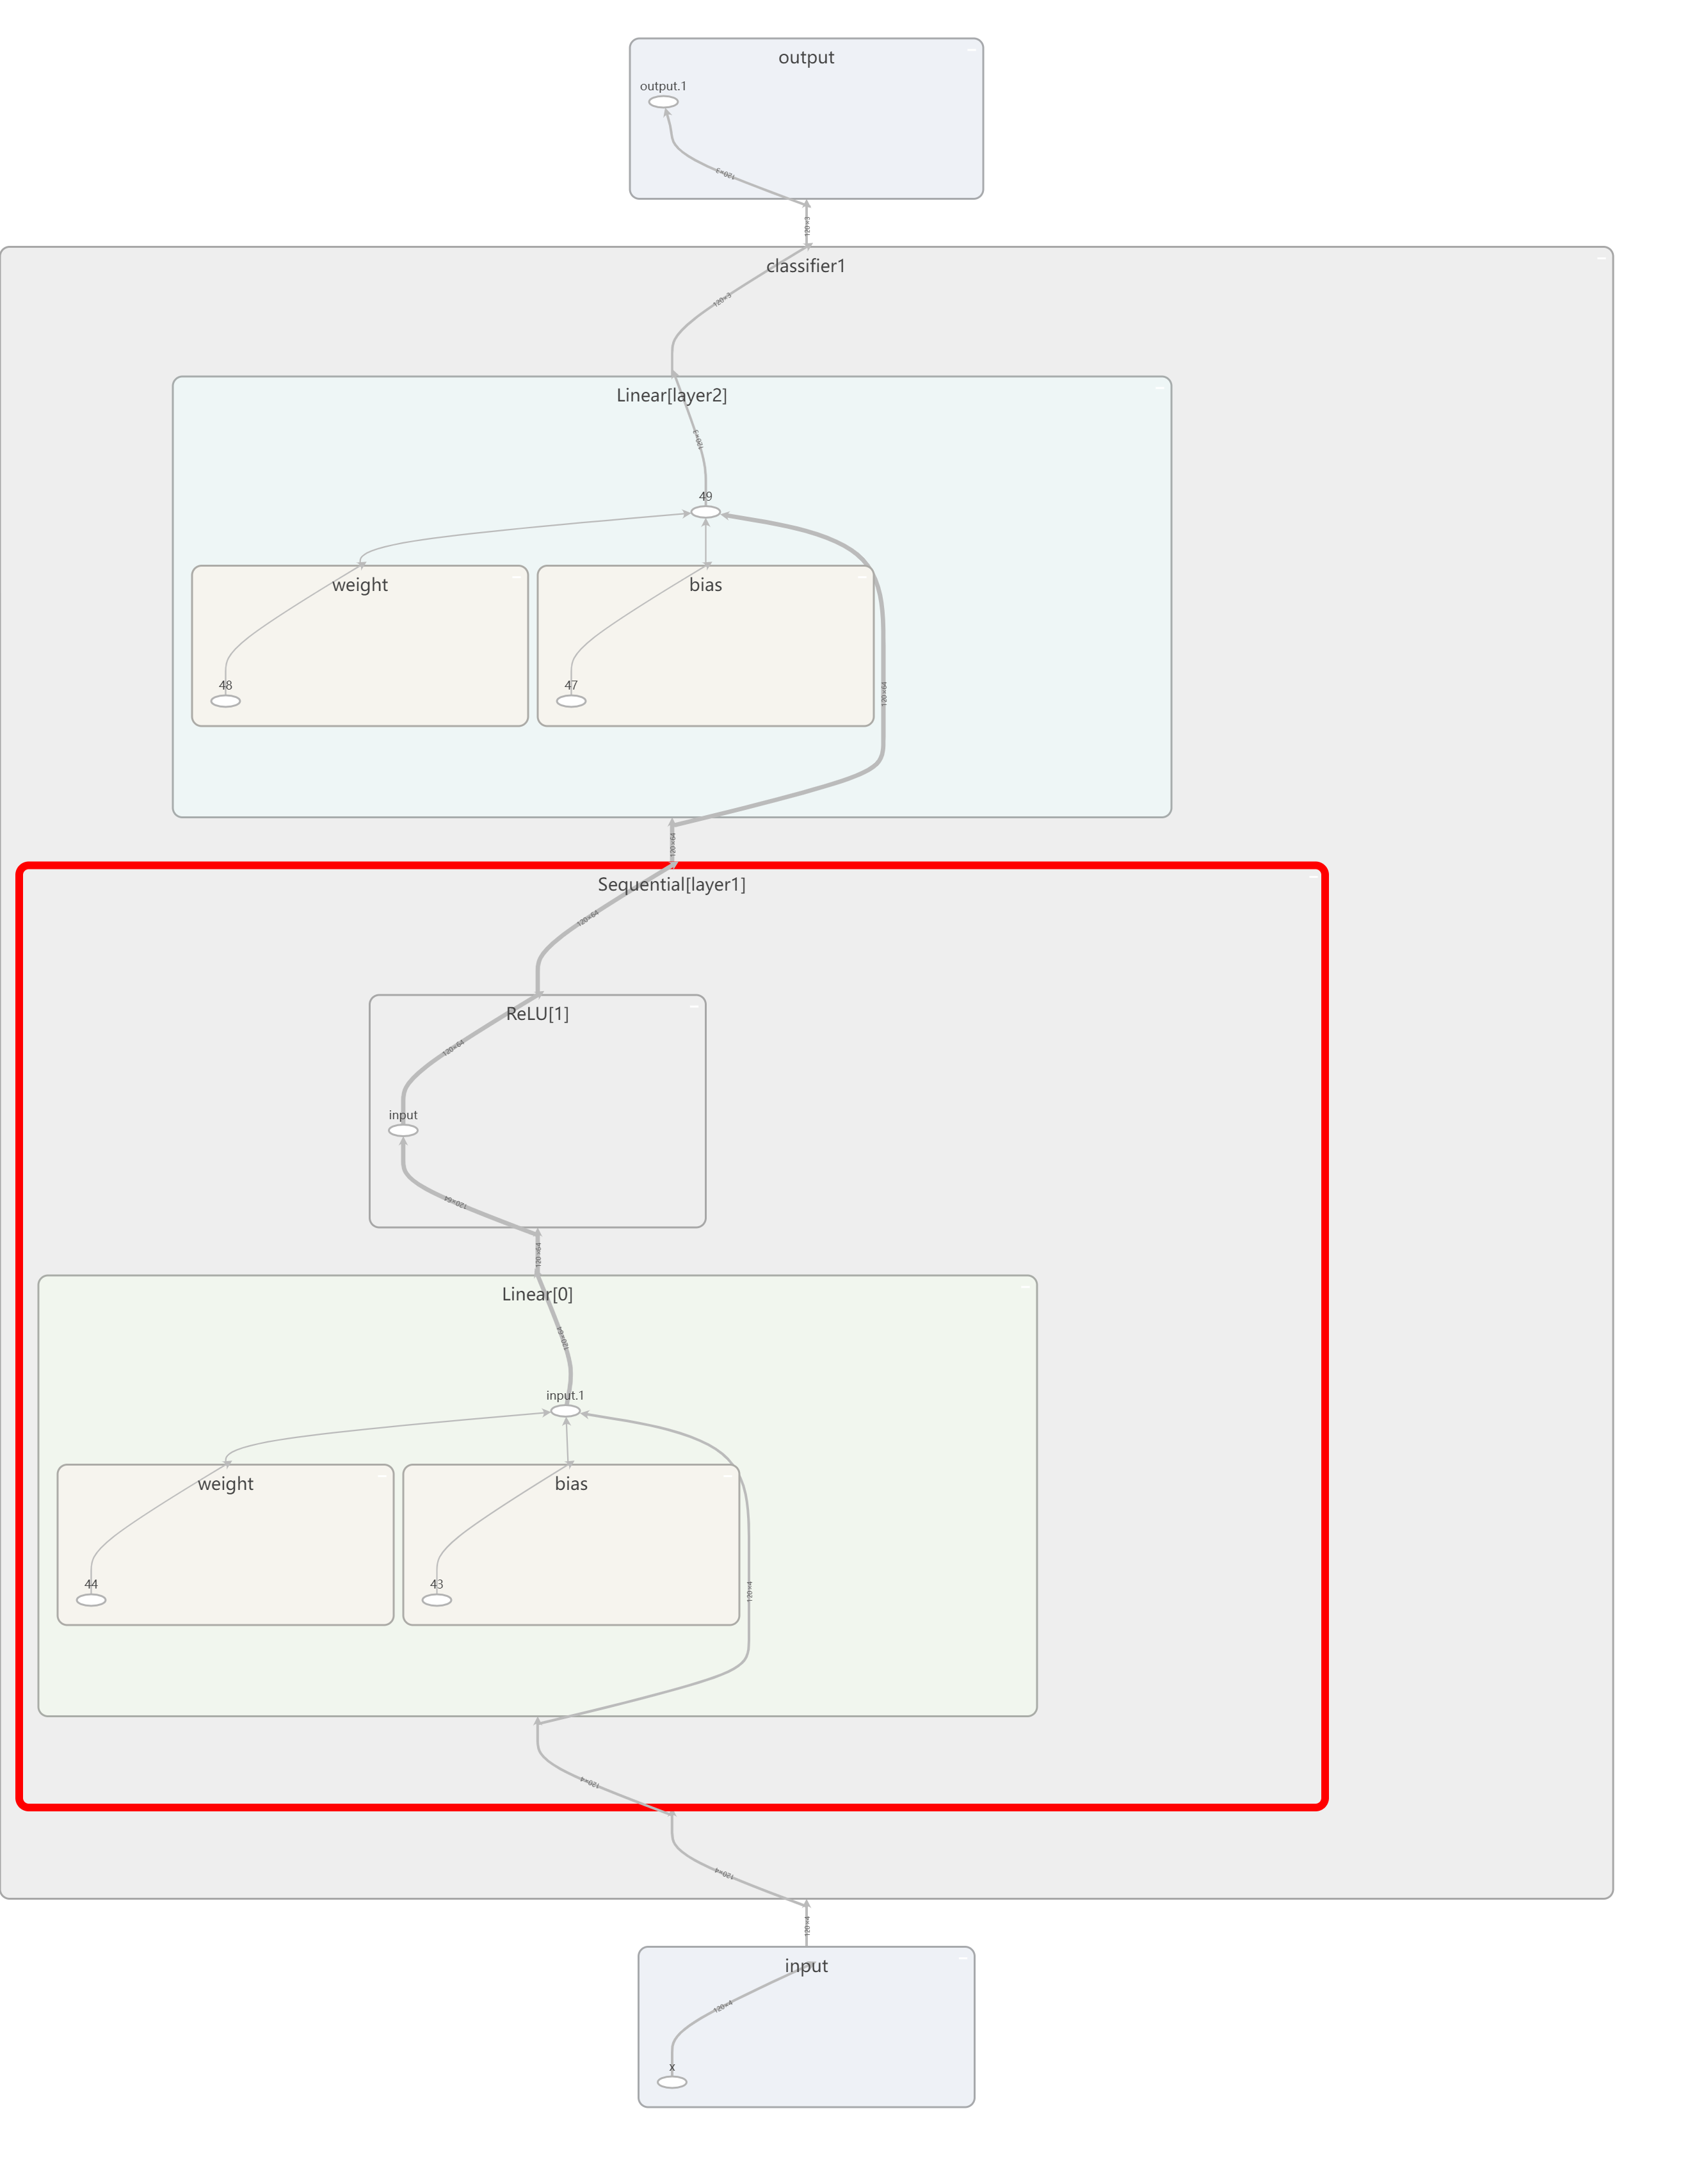


In [53]:
#Adam优化算法
num_epoches = 100
trainloader = DataLoader(train_dataset,batch_size=20,shuffle=True)
model1 = classifier1()
optimizer11 = optim.Adam(model1.parameters(), lr=0.1, betas=(0.9,0.999), eps=1e-08, weight_decay=0.1)
out11,train_loss1 = train_model(model1,optimizer11,trainloader)
ypre1 = re_ypre(out11)
con_matrix1 = confusion_matrix(ytest_data,ypre1)
print('1(64)&Adam(weight_decay=0.1)在测试集上的混淆矩阵\n',con_matrix1)

1(64)&Adam(weight_decay=0.1)在测试集上的混淆矩阵
 [[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


In [54]:
#Adam优化算法，与上面参数不同
model2 = classifier1()
optimizer12 = optim.Adam(model2.parameters(), lr=0.1, betas=(0.9,0.999), eps=1e-08, weight_decay=0)
out12,train_loss2 = train_model(model2,optimizer12,trainloader)
ypre2 = re_ypre(out12)
con_matrix2 = confusion_matrix(ytest_data,ypre2)
print('1(64)&Adam(weight_decay=0)在测试集上的混淆矩阵\n',con_matrix2)

1(64)&Adam(weight_decay=0)在测试集上的混淆矩阵
 [[ 9  1  0]
 [ 0 10  0]
 [ 0  0 10]]


In [55]:
#SGD随机梯度下降优化算法
model3 = classifier1()
optimizer13 = optim.SGD(model3.parameters(), lr=0.1, weight_decay= 0, momentum = 0.5, nesterov = True)
out13,train_loss3 = train_model(model3,optimizer13,trainloader)
ypre3 = re_ypre(out13)
con_matrix3 = confusion_matrix(ytest_data,ypre3)
print('1(64)&SGD在测试集上的混淆矩阵\n',con_matrix3)

1(64)&SGD在测试集上的混淆矩阵
 [[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


In [56]:
#Adadelta优化算法
model4 = classifier1()
optimizer14 = optim.Adadelta(model4.parameters(), lr=0.4, rho=0.9, eps=1e-08, weight_decay=0.1)
out14,train_loss4 = train_model(model4,optimizer14,trainloader)
ypre4 = re_ypre(out14)
con_matrix4 = confusion_matrix(ytest_data,ypre4)
print('1(64)&Adadelta在测试集上的混淆矩阵\n',con_matrix4)

1(64)&Adadelta在测试集上的混淆矩阵
 [[10  0  0]
 [ 0  8  2]
 [ 0  0 10]]


In [57]:
#Adagrad优化算法
model5 = classifier1()
optimizer15 = optim.Adagrad(model5.parameters(), lr=0.1, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
out15,train_loss5 = train_model(model5,optimizer15,trainloader)
ypre5 = re_ypre(out15)
con_matrix5 = confusion_matrix(ytest_data,ypre5)
print('1(64)&Adagrad在测试集上的混淆矩阵\n',con_matrix5)

1(64)&Adagrad在测试集上的混淆矩阵
 [[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


In [58]:
#RMSprop优化算法
model6 = classifier1()
optimizer16 = optim.RMSprop(model6.parameters(), lr=0.01, alpha=0.99, weight_decay=0, momentum=0)
out16,train_loss6 = train_model(model6,optimizer16,trainloader)
ypre6 = re_ypre(out16)
con_matrix6 = confusion_matrix(ytest_data,ypre6)
print('1(64)&RMSprop在测试集上的混淆矩阵\n',con_matrix6)

1(64)&RMSprop在测试集上的混淆矩阵
 [[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


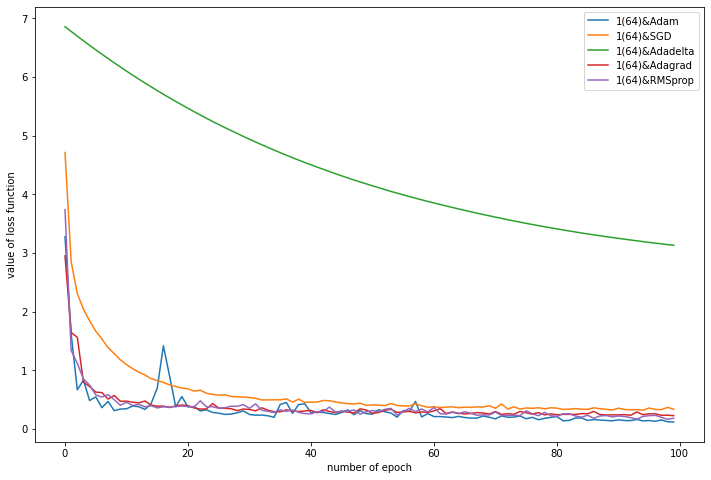

In [59]:
fig = plt.figure(figsize=(12,8))
plt.plot(list(range(num_epoches)),train_loss2,label='1(64)&Adam')
plt.plot(list(range(num_epoches)),train_loss3,label='1(64)&SGD')
plt.plot(list(range(num_epoches)),train_loss4,label='1(64)&Adadelta')
plt.plot(list(range(num_epoches)),train_loss5,label='1(64)&Adagrad')
plt.plot(list(range(num_epoches)),train_loss6,label='1(64)&RMSprop')
plt.xlabel('number of epoch')
plt.ylabel('value of loss function')
plt.legend()
plt.show()

除Adadelta外几种优化算法最终都将损失降到一个大致的区间内，但可以看到前期差距较大，这与该优化算法本身的性能有关，比如Adam算法不太稳定，损失值在中后期波动幅度较大；SGD的损失值下降相较其他算法是比较慢的；效果最差的是Adadelta算法，该算法分母中对历史梯度一直在做累加，学习率将逐渐下降至0，会导致整个训练过程的学习率一直很小，因此初始学习率设置太小结果会更加差一些，学习时间也很长。

#尝试使用随机梯度下降训练模型，并比较使用不同的 Batchsize(每次用于训练神经网络的样本数量)时，模型训练的效果。

In [51]:
#batch_size取值（1，120，10）
model = classifier1()    
acc_list = []
loss_list = []
for i in range(1,120,10):
    trainloader1 = DataLoader(train_dataset,batch_size=i,shuffle=False)
    optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay= 0, momentum = 0.9)
    out1,train_loss = train_model(model,optimizer,trainloader1)
    loss_list.append(sum(train_loss)/len(train_loss))
    ypre1 = re_ypre(out1)
    acc = accuracy_score(ytest_data,ypre1)
    acc_list.append(acc)
    model = classifier1()

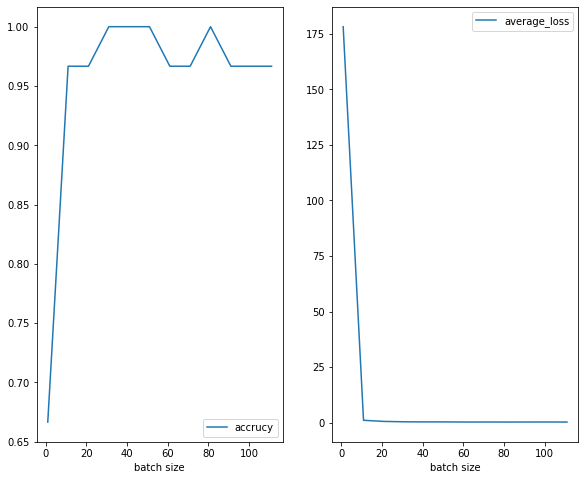

In [52]:
plt.figure(figsize=(15,8))
plt.subplot(131)
plt.plot(list(range(1,120,10)),acc_list,label='accrucy')
plt.xlabel('batch size')
plt.legend()
plt.subplot(132)
plt.plot(list(range(1,120,10)),loss_list,label = 'average_loss')
plt.xlabel('batch size')
plt.legend()
plt.legend()
plt.show()

只有当batch_size特别小时，预测效果不大好，在batch_size>20时效果都不错，一个原因是训练数据太少了，batch_size的大小本就影响不大

#尝试不同的隐藏层和节点

In [61]:
# 两个隐藏层，各有32个节点 
class classifier2(nn.Module):
    def __init__(self,):
        super(classifier2,self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(4,32),nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(nn.Linear(32,32),nn.ReLU(inplace=True))
        self.layer3 = nn.Linear(32,3)
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [43]:
best_loss = 10
num_epoches = 100
train_loss0 = []
model = classifier2()
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9,0.999), eps=1e-08, weight_decay=0)
for epoch in range(num_epoches): 
    x = xtrain_data
    label = ytrain_data
    x = x.to(torch.float32)
    label = label.long()
    optimizer.zero_grad()
    output = model(x)
    loss = loss_function(output, label)
    loss.backward()
    optimizer.step()
    train_loss0.append(loss)
    if loss < best_loss :
        best_loss = loss
        best_model_wts = copy.deepcopy(model.state_dict())
model.load_state_dict(best_model_wts)
with SummaryWriter(comment='classifier2')as w:
    w.add_graph(model, (x,))

#生成网络结构图

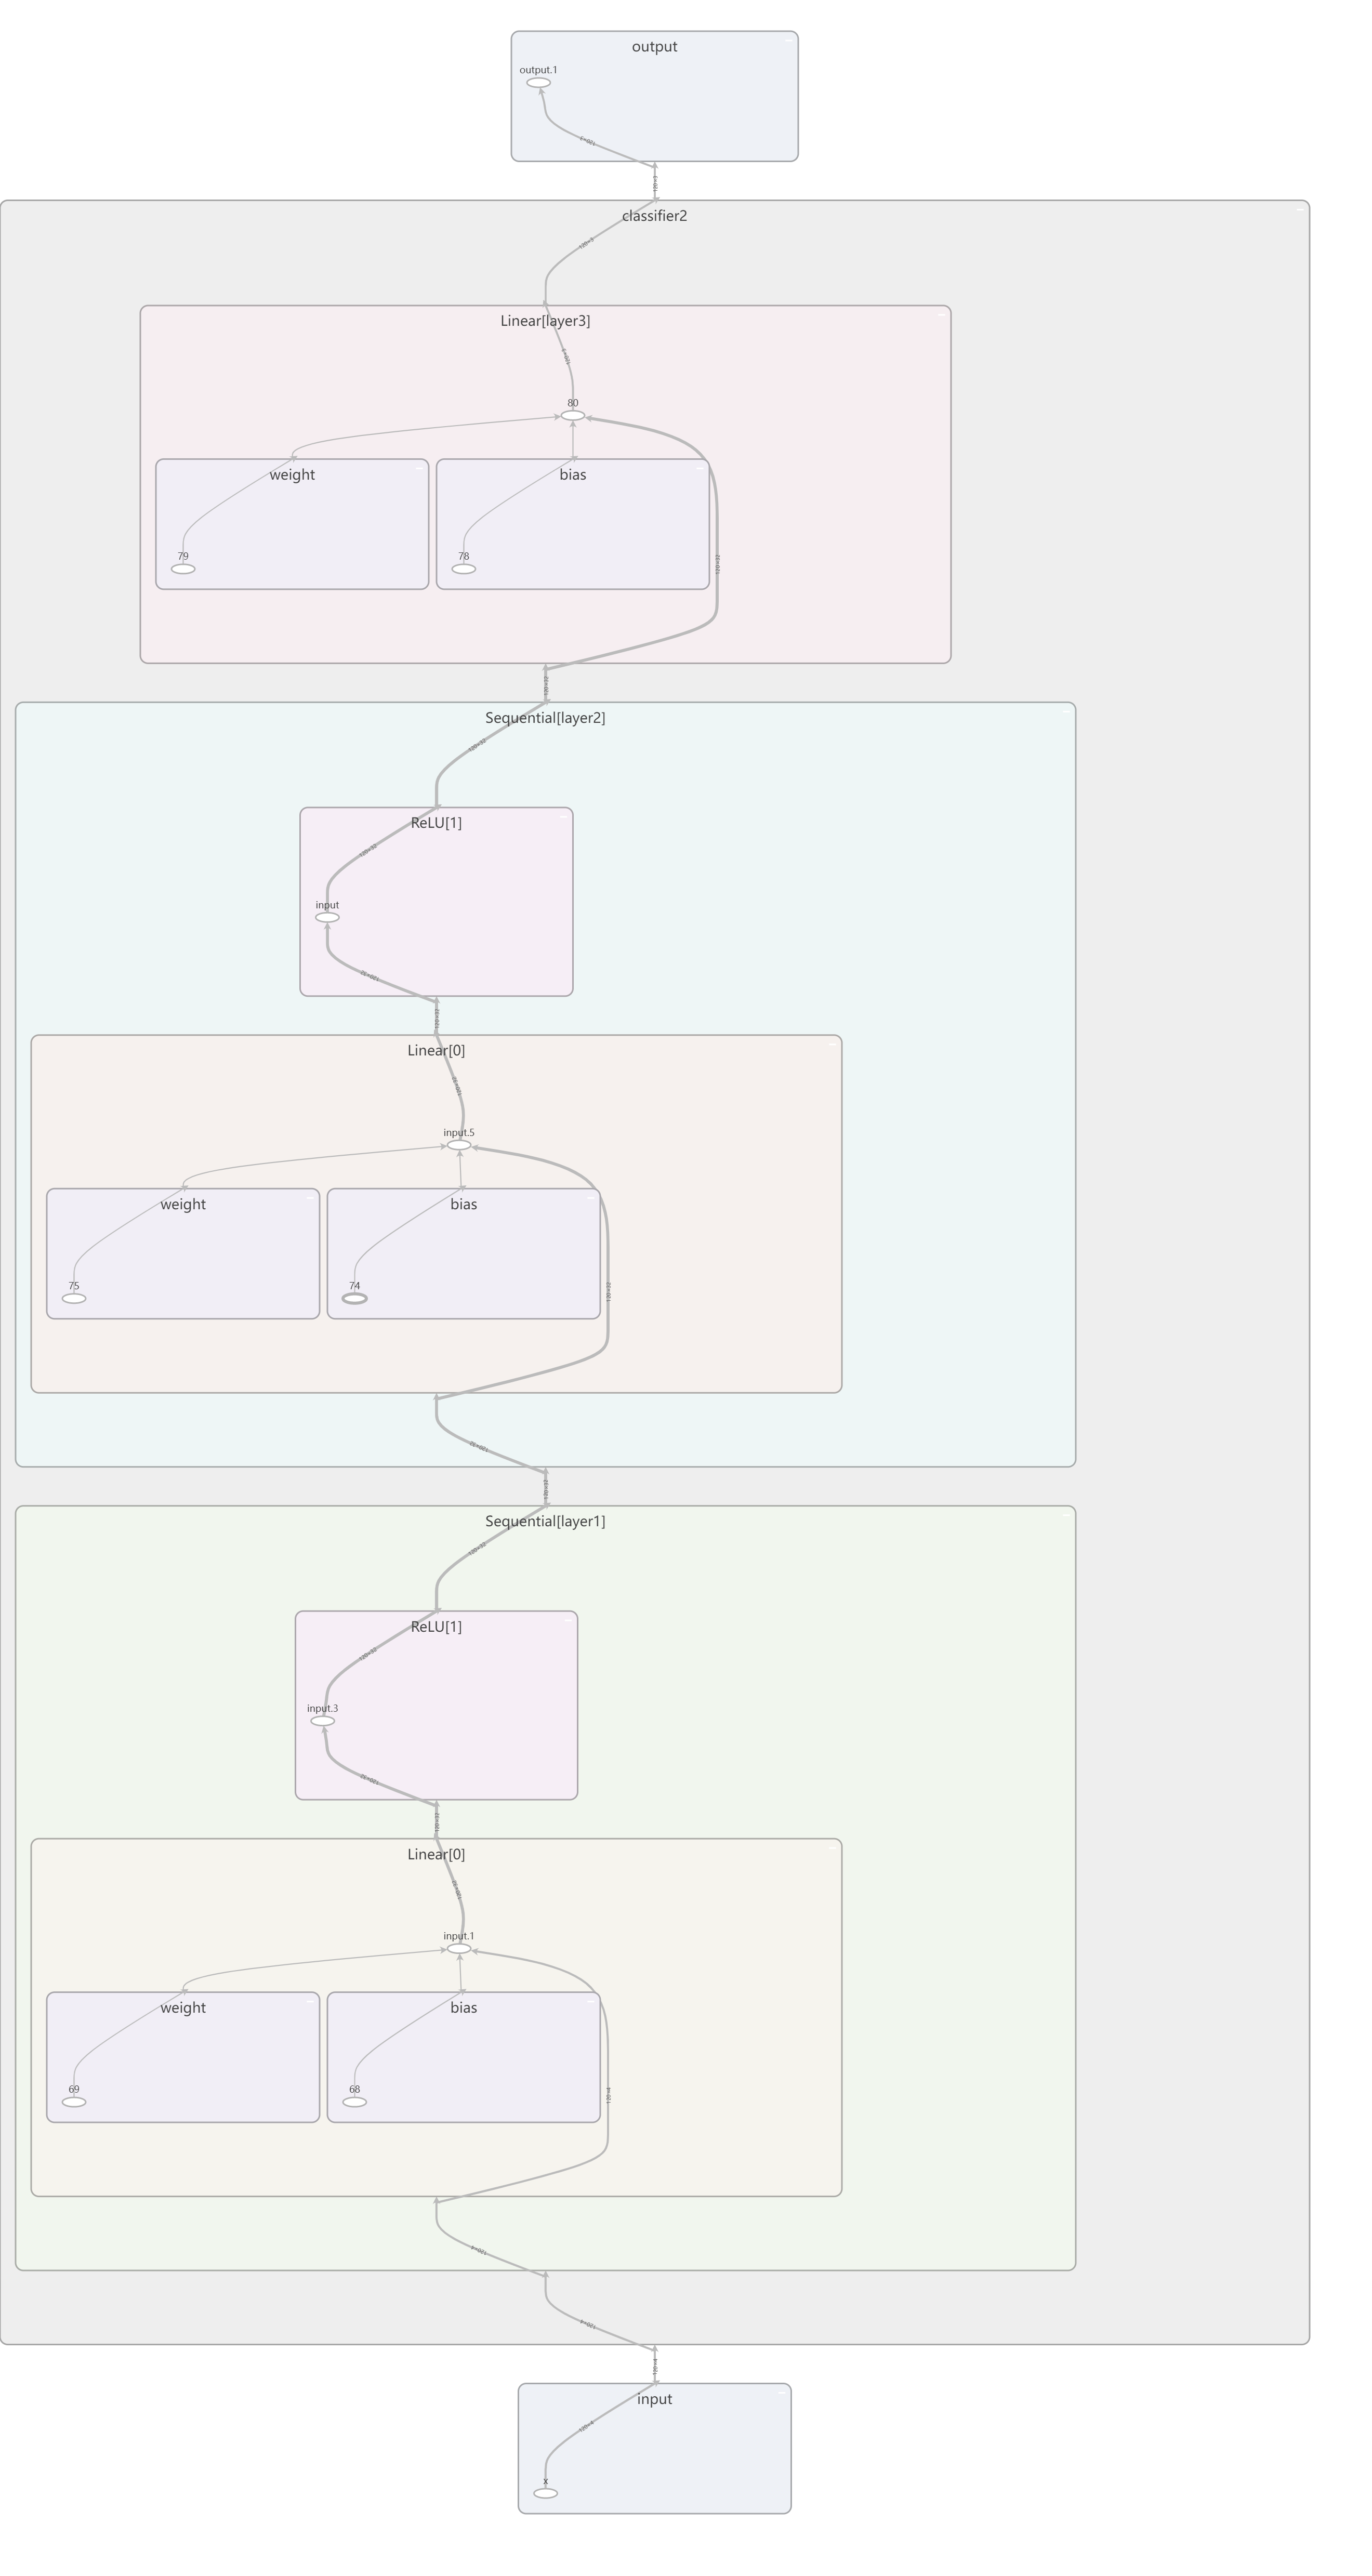

In [74]:
model2 = classifier2()
optimizer21 = optim.Adam(model2.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
out21,train_loss21 = train_model(model2,optimizer21,trainloader)
ypre1 = re_ypre(out21)
con_matrix1 = confusion_matrix(ytest_data,ypre1)
print('1(32)+1(32)&Adam在测试集上的混淆矩阵\n',con_matrix1)

1(32)+1(32)&Adam在测试集上的混淆矩阵
 [[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


In [67]:
# 一个隐藏层，只有16个节点 
class classifier3(nn.Module):
    def __init__(self,):
        super(classifier3,self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(4,16),nn.ReLU(inplace=True))
        self.layer2 = nn.Linear(16,3)
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out

In [76]:
model3 = classifier3()
optimizer22 = optim.Adam(model3.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
out22,train_loss22 = train_model(model3,optimizer22,trainloader)
ypre2 = re_ypre(out22)
con_matrix2 = confusion_matrix(ytest_data,ypre2)
print('1(16)&Adam在测试集上的混淆矩阵\n',con_matrix2)

1(16)&Adam在测试集上的混淆矩阵
 [[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


In [82]:
# 三个隐藏层，分别有16，32，16个节点 
class classifier4(nn.Module):
    def __init__(self,):
        super(classifier4,self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(4,16),nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(nn.Linear(16,32),nn.ReLU(inplace=True))
        self.layer3 = nn.Sequential(nn.Linear(32,16),nn.ReLU(inplace=True))
        self.layer4 = nn.Linear(16,3)
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

In [83]:
model4 = classifier4()
optimizer23 = optim.Adam(model4.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
out23,train_loss23 = train_model(model4,optimizer23,trainloader)
ypre3 = re_ypre(out23)
con_matrix3 = confusion_matrix(ytest_data,ypre3)
print('1(16)+1(32)+1(16)&Adam在测试集上的混淆矩阵\n',con_matrix3)

1(16)+1(32)+1(16)&Adam在测试集上的混淆矩阵
 [[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


In [92]:
# 一个隐藏层，108个节点 
class classifier5(nn.Module):
    def __init__(self,):
        super(classifier5,self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(4,128),nn.ReLU(inplace=True))
        self.layer2 = nn.Linear(128,3)
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out

In [100]:
model5 = classifier5()
optimizer24 = optim.Adam(model5.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
out24,train_loss24 = train_model(model5,optimizer24,trainloader)
ypre4 = re_ypre(out24)
con_matrix4 = confusion_matrix(ytest_data,ypre4)
print('1(128)&Adam在测试集上的混淆矩阵\n',con_matrix4)

1(128)&Adam在测试集上的混淆矩阵
 [[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


In [97]:
# 四个隐藏层，分别有16，32，64，16个节点
class classifier6(nn.Module):
    def __init__(self,):
        super(classifier6,self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(4,16),nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(nn.Linear(16,32),nn.ReLU(inplace=True))
        self.layer3 = nn.Sequential(nn.Linear(32,64),nn.ReLU(inplace=True))
        self.layer4 = nn.Sequential(nn.Linear(64,16),nn.ReLU(inplace=True))
        self.layer5 = nn.Linear(16,3)
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        return out

In [98]:
model5 = classifier6()
optimizer25 = optim.Adam(model6.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
out25,train_loss25 = train_model(model6,optimizer25,trainloader)
ypre5 = re_ypre(out25)
con_matrix5 = confusion_matrix(ytest_data,ypre5)
print('1(16)+1(32)+1(64)+1(16)&Adam在测试集上的混淆矩阵\n',con_matrix5)

1(16)+1(32)+1(64)+1(16)&Adam在测试集上的混淆矩阵
 [[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


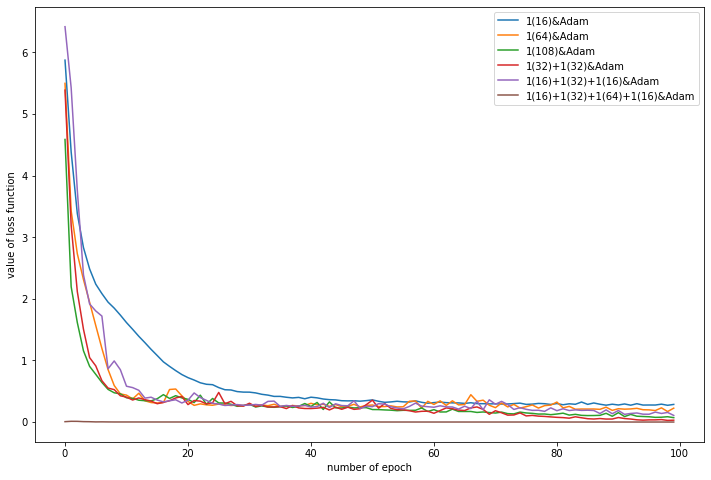

In [101]:
fig = plt.figure(figsize=(12,8))
plt.plot(list(range(num_epoches)),train_loss22,label='1(16)&Adam')
plt.plot(list(range(num_epoches)),train_loss1,label='1(64)&Adam')
plt.plot(list(range(num_epoches)),train_loss24,label='1(108)&Adam')
plt.plot(list(range(num_epoches)),train_loss21,label='1(32)+1(32)&Adam')
plt.plot(list(range(num_epoches)),train_loss23,label='1(16)+1(32)+1(16)&Adam')
plt.plot(list(range(num_epoches)),train_loss25,label='1(16)+1(32)+1(64)+1(16)&Adam')
plt.xlabel('number of epoch')
plt.ylabel('value of loss function')
plt.legend()
plt.show()

尝试了以下几种神经网络结构：
1、一个隐藏层，只有16个节点
2、一个隐藏层，64个节点
3、一个隐藏层，108个节点
4、两个隐藏层，各有32个节点
5、三个隐藏层，分别有16，32，16个节点
6、四个隐藏层，分别有16，32，64，16个节点
损失函数降得最慢的是只有一个隐藏层、16个节点的神经网络，层数少、节点少时学习到的特征不够充分，训练效果不够好。但隐藏层和节点增多后（特别是第6种情况）损失值下降的比较奇怪，怀疑存在过拟合情况，但是测试集数据太少了，看不出来测试结果很差。